# Initial processing


In [2]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from util import *
import matplotlib.pyplot as plt
%matplotlib inline
import gc

Loading data

In [3]:
# Loading Train Dataset
train_transaction = pd.read_csv('dataset/train_transaction.csv')
train_identity = pd.read_csv('dataset/train_identity.csv')

# Loading Test Dataset
test_transaction = pd.read_csv('dataset/test_transaction.csv')
test_identity = pd.read_csv('dataset/test_identity.csv')


Merging transaction and identity files


In [4]:
# Merging the transaction and identity dataset
train_data = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity

test_data = test_transaction.merge(test_identity, how='left', on='TransactionID')
del test_transaction, test_identity

gc.collect()
train_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


Resolve train and test data mismatch (id- and id_)

In [5]:
# test_data has a mismatch with the train data in the names of the id features, in the train data we have the id 
# feature as id_x but in the test data we have the id feature as id-x and hence we will be making all names the 
# id features in the test data same as the names of the id features of the train data 

test_data.columns = test_data.columns.str.replace('^id-', 'id_', regex=True)

Checking for Duplicate Rows in the training set

In [6]:
duplicate_rows = train_data[train_data.duplicated()]  
print("Duplicate Rows :", duplicate_rows)

Duplicate Rows : Empty DataFrame
Columns: [TransactionID, isFraud, TransactionDT, TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, dist2, P_emaildomain, R_emaildomain, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, M1, M2, M3, M4, M5, M6, M7, M8, M9, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, ...]
Index: []

[0 rows x 434 columns]


Saving the merged train and test dataset into pickle format

In [7]:
train_data.to_pickle('dataset/merged_train.pkl')
test_data.to_pickle('dataset/merged_test.pkl')

del train_data, test_data
gc.collect()

8

# Data preparation

- Stored the “isFraud” column of train_dataset as y_train.
- Dropped “TransactionID” column from both the datasets since it was only a unique identifier for each of the transactions and was of no use in deciding the Transaction Status.
- Dropped the “isFraud” column from the train_dataset.
- Dropped the “TransactionID” column of test_dataset.
- Stored the modified train_dataset and test_datasets as X_train and X_test respectively.
- Imputed all the non-numeric categorical missing values of the X_train and X_test with “missing”.
- Label Encoded the Non-Numeric Features of X_train.
- Label Encoded the Non-Numeric Features of X_test using the X_train. The main thing that I kept in my mind is to avoid test data leakage, often in Kaggle Competitions, Kagglers use the leakages from test data so as to get higher score but this technique (more of a shortcut) is only limited to Kaggle Competitions only. Hence, I approached the problem keeping in mind the real world constraints and tried to avoid test data leakage to the best of my ability.

Now, using X_train and X_test, we created three different sets (X_train1, X_test1), (X_train2, X_test2) and (X_train3, X_test3) each having the following characteristics,
- The missing values of Set1 were imputed using -999 and the dataset was column normalized so as to be used with non-tree based models.
- The missing values of Set2 were imputed using -999 but the dataset was not normalized so as to be used with - Decision Tree, Random Forest and Adaptive Boosting.
- Set3 was left untouched since XGBoost was used for applying GBDT and it can handle the missing values implicitly.

## Initialization

Loading the merged train and test dataset

In [26]:
train_data = pd.read_pickle('dataset/merged_train.pkl')
test_data = pd.read_pickle('dataset/merged_test.pkl')

In [27]:
print("Train Data Shape : {} \n".format(train_data.shape))
print("Test Data Shape : {} \n".format(test_data.shape))

Train Data Shape : (590540, 434) 

Test Data Shape : (506691, 433) 



In [30]:
columns_def = pd.DataFrame({"NA_count":train_data.isnull().sum().sort_values(ascending=False)})
columns_def["Per"]=columns_def["NA_count"]/len(train_data)
columns_def.head(50)

,NA_count,Per
id_24,585793,0.991962
id_25,585408,0.991310
id_07,585385,0.991271
id_08,585385,0.991271
id_21,585381,0.991264
id_26,585377,0.991257
id_27,585371,0.991247
id_23,585371,0.991247
id_22,585371,0.991247
dist2,552913,0.936284


## Generate time features

Create day column

In [10]:
train_data['day'] = (train_data['TransactionDT']//(3600*24)-1)%7
test_data['day'] = (test_data['TransactionDT']//(3600*24)-1)%7

<AxesSubplot:xlabel='day', ylabel='percentage'>

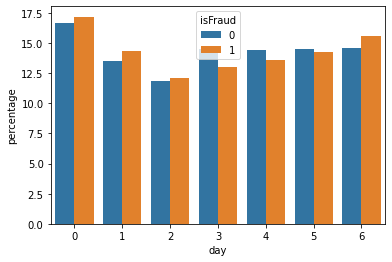

In [11]:
train_day = (train_data.groupby(['isFraud'])['day']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('day'))
sns.barplot(x="day", y="percentage", hue="isFraud", data=train_day)

Create hour column

In [12]:
train_data['hour'] = (train_data['TransactionDT']//(3600))%24
test_data['hour'] = (test_data['TransactionDT']//(3600))%24

<AxesSubplot:xlabel='hour', ylabel='percentage'>

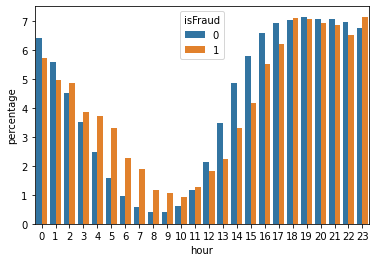

In [13]:
train_hour = (train_data.groupby(['isFraud'])['hour']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('hour'))
sns.barplot(x="hour", y="percentage", hue="isFraud", data=train_hour)

## Basic steps

Splitting the Dataset

In [14]:
X_train = train_data.drop(['isFraud', 'TransactionID'], axis=1)
y_train = train_data['isFraud']

X_test = test_data.drop(['TransactionID'], axis=1)
test_ids = test_data['TransactionID'].values

del train_data, test_data
gc.collect()

0

Storing Categorical and Numerical Feature Names 

In [15]:
catf, numf = cat_num_features(X_train)
categorical_feature_indices = [X_train.columns.get_loc(f) for f in catf]

Label Encoding Categorical Features

In [16]:
# Imputing the missing values of Categorical Columns with "missing"
X_train[catf] = X_train[catf].fillna('missing')
X_test[catf] = X_test[catf].fillna('missing')


# Label Encoding Categorical Features
X_train, X_test = label_encode(X_train, X_test, catf)

In [17]:
X_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour
0,86400,68.5,4,3417,500,42,1,38,1,166,...,260,4,2,2,2,2,1,1735,0,0
1,86401,29.0,4,7922,303,42,2,2,1,173,...,260,4,2,2,2,2,1,1735,0,0
2,86469,59.0,4,9383,389,42,4,58,2,178,...,260,4,2,2,2,2,1,1735,0,0
3,86499,50.0,4,6991,466,42,2,14,2,282,...,260,4,2,2,2,2,1,1735,0,0
4,86506,50.0,1,9262,413,42,2,2,1,241,...,164,3,1,0,1,1,2,954,0,0


In [18]:
X_test.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour
0,18403224,31.95,4,365,10,42,4,108,2,52,...,260,4,2,2,2,2,1,1735,2,0
1,18403263,49.00,4,9099,10,42,4,108,2,151,...,260,4,2,2,2,2,1,1735,2,0
2,18403310,171.00,4,9245,473,42,4,108,2,280,...,260,4,2,2,2,2,1,1735,2,0
3,18403310,284.95,4,870,259,42,4,58,2,79,...,260,4,2,2,2,2,1,1735,2,0
4,18403317,67.95,4,6894,351,42,2,14,2,127,...,260,4,2,2,2,2,1,1735,2,0


In [19]:
print("Train Data Shape : {} \n".format(X_train.shape))
print("Test Data Shape : {} \n".format(X_test.shape))

Train Data Shape : (590540, 434) 

Test Data Shape : (506691, 434) 



Remove columns with >= 99% missing values

In [1]:
# train = X_train.dropna(axis=1, how='any', thresh=0.99*X_train.shape[0], subset=None, inplace=False)
# test = X_test.dropna(axis=1, how='any', thresh=0.99*X_test.shape[0], subset=None, inplace=False)
# X_train.head()

# columns_def = pd.DataFrame({"NA_count":X_train.isnull().sum().sort_values(ascending=False)})
# columns_def["Per"]=columns_def["NA_count"]/len(X_train)

# print("Train Data Shape : {} \n".format(X_train.shape))
# print("Test Data Shape : {} \n".format(X_test.shape))

# columns_def.head()

## Final steps

In [ ]:
# Set1 (Imputed and Normalized)
X_train1 = X_train.fillna(-999)
X_test1 = X_test.fillna(-999)
X_train1, X_test1 = normalize(X_train1, X_test1)

# Set2 (Imputed)
X_train2 = X_train.fillna(-999)
X_test2 = X_test.fillna(-999)

# Set3 (Raw)
X_train3 = X_train
X_test3 = X_test

del X_train, X_test
gc.collect()

In [ ]:
train1 = X_train1
train1['isFraud'] = y_train

test1 = X_test1

del X_train1, X_test1



train2 = X_train2
train2['isFraud'] = y_train

test2 = X_test2

del X_train2, X_test2



train3 = X_train3
train3['isFraud'] = y_train

test3 = X_test3

del X_train3, y_train, X_test3
gc.collect()

In [ ]:
y_train = train1.pop('isFraud')
_ = train2.pop('isFraud')
_ = train3.pop('isFraud')


X_train1 = train1
X_test1 = test1 

X_train2 = train2
X_test2 = test2 

X_train3 = train3
X_test3 = test3 

del train1, train2, train3
gc.collect()